In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Regression Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

In [5]:

## Preparing Data
df = pd.read_csv('../dataset_new.csv')
df.head(5)

,LOTE,Fecha/hora inicio_preinoculo,Fecha/hora fin_preinoculo,línea 1,línea 2,línea 3,línea 1.1,línea 2.1,línea 3.1,línea 1.2,...,Centrifugación 1 turbidez,Centrifugación 2 turbidez,Producto 1,Producto 2,media_PV,temperature_preinoculo,humedad_preinoculo,media_temp_bioreactor,media_ph_biorreactor,media_PO_biorreactor
0,23019,2023-03-19 05:00:00,2023-03-20 07:24:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1747.920,6.00,0.330522,20.157241,50.339050,29.689535,6.191826,24.355140
1,23020,2023-03-19 05:00:00,2023-03-20 07:24:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1676.160,6.56,0.426711,20.157241,50.339050,29.689535,6.191826,24.355140
2,23021,2023-03-20 05:00:00,2023-03-21 06:37:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1928.496,8.08,0.409436,20.173527,52.099099,29.439842,6.028036,25.462923
3,23022,2023-03-20 05:00:00,2023-03-21 06:37:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1782.800,5.92,0.080985,20.173527,52.099099,29.439842,6.028036,25.462923
4,23023,2023-03-26 05:00:00,2023-03-27 07:21:00,5.496,5.504,5.5200000000000005,28.32,27.92,32,1.0,...,26.56,20.88,1861.840,2.96,0.368708,20.251146,48.900195,29.442474,6.002998,23.396945


In [6]:
target = df.iloc[:, 41]
columns_to_drop = df.iloc[:, [0, 1, 2, 13, 14, 12, 22, 23, 24, 30, 31, 32, 33, 38, 41, 42]].columns

df_dropped = df.drop(columns=columns_to_drop)
data = df_dropped
data.replace('N.A', np.nan, inplace=True)
data['línea 3'] = data['línea 3'].astype(float)
data['línea 3.1'] = data['línea 3.1'].astype(float)
data['Viabilidad final cultivo_cultivo_final'] = data['Viabilidad final cultivo_cultivo_final'].astype(float)


def clean_and_convert(column):
    # Reemplazar ',' por '.' y eliminar el signo '+'
    column = column.str.replace(',', '.', regex=False)
    column = column.str.replace('+', '', regex=False)
    # Convertir a float, forzando errores a NaN
    return pd.to_numeric(column, errors='coerce')


# Aplicar la función a todas las columnas de tipo object
for col in data.select_dtypes(include=['object']).columns:
    data[col] = clean_and_convert(data[col])
for column in data.select_dtypes(include=[np.number]).columns:
    mean_value = data[column].mean()
    print(mean_value)
    data[column].fillna(mean_value, inplace=True)
for column in data.select_dtypes(exclude=[np.number]).columns:
    mode_value = data[column].mode()[0]  # Use the most frequent value
    data[column].fillna(mode_value, inplace=True)
# Definir características (X) y objetivo (y)
X = data
y = target
# Dividir el dataset en entrenamiento, validación y prueba
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)  # 60% entrenamiento
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 20% validación, 

5.468736
5.470035087719299
5.498217821782178
32.061440000000005
30.212631578947367
29.801188118811883
0.8188976377952756
0.6456692913385826
0.41732283464566927
150.5514503816794
15.36064
26.362137404580157
99092268.70229007
13.696641221374044
20.1720479825518
44926560.913380995
150.5514503816794
15.36064
26.362137404580157
99092268.70229007
1.0
81.55658914728681
17.380763358778626
74.06106870229007
168240203.56234095
30.287401574803148
23.35516129032258
0.3661848971527833
20.16984734592939
47.94785228808695
29.45899697760463
6.965512947242943
27.171243680776026


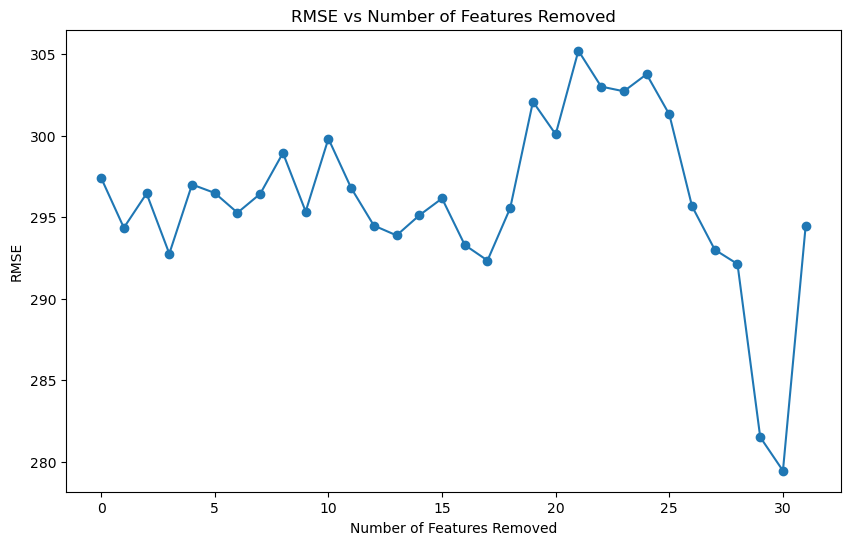

Best Features: ['Turbidez fin cultivo', 'media_PV', 'Centrifugación 1 turbidez']
Lowest RMSE: 279.46046962362


In [5]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Initial training
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get initial feature importances
importances = rf.feature_importances_
feature_names = X_train.columns
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Store RMSE values
rmse_values = []
features_list = []

# Iteratively remove the least important feature
while len(feature_importances) > 1:
    # Evaluate the model
    y_pred = rf.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmse_values.append(rmse)
    features_list.append(feature_importances['Feature'].tolist())

    # Remove the least important feature
    least_important_feature = feature_importances.iloc[-1, 0]
    X_train = X_train.drop(columns=[least_important_feature])
    X_val = X_val.drop(columns=[least_important_feature])

    # Retrain the model
    rf.fit(X_train, y_train)

    # Get new feature importances
    importances = rf.feature_importances_
    feature_names = X_train.columns
    feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot RMSE values
plt.figure(figsize=(10, 6))
plt.plot(range(len(rmse_values)), rmse_values, marker='o')
plt.xlabel('Number of Features Removed')
plt.ylabel('RMSE')
plt.title('RMSE vs Number of Features Removed')
plt.show()

# Print the features that resulted in the lowest RMSE
min_rmse_index = np.argmin(rmse_values)
best_features = features_list[min_rmse_index]
print("Best Features:", best_features)
print("Lowest RMSE:", rmse_values[min_rmse_index])

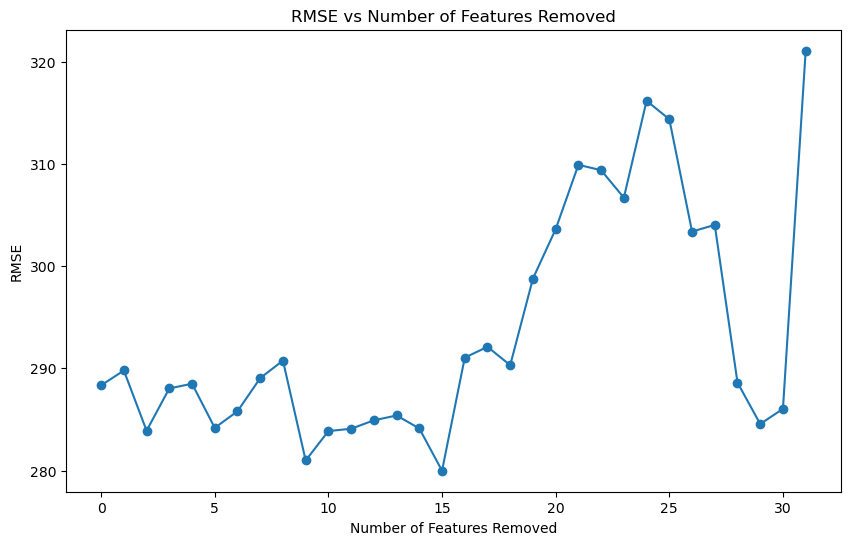

Best Features: ['Turbidez fin cultivo', 'media_PV', 'Centrifugación 2 turbidez', 'Centrifugación 1 turbidez', 'Volumen de cultivo_inoculo', 'media_temp_bioreactor', 'Volumen de inóculo utilizado', 'Viabilidad final cultivo', 'Turbidez final culttivo_inoculo', 'Volumen de cultivo', 'Turbidez inicio cultivo_cultivo_final', 'Viabilidad final cultivo_inoculo', 'temperature_preinoculo', 'Viabilidad final cultivo_cultivo_final', 'línea 1.1', 'media_ph_biorreactor', 'Turbidez', 'línea 3.1']
Lowest RMSE: 279.9904128469281


In [4]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Initial training
gbr = GradientBoostingRegressor(n_estimators=100, random_state=42)
gbr.fit(X_train, y_train)

# Get initial feature importances
importances = gbr.feature_importances_
feature_names = X_train.columns
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Store RMSE values
rmse_values = []
features_list = []

# Iteratively remove the least important feature
while len(feature_importances) > 1:
    # Evaluate the model
    y_pred = gbr.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmse_values.append(rmse)
    features_list.append(feature_importances['Feature'].tolist())

    # Remove the least important feature
    least_important_feature = feature_importances.iloc[-1, 0]
    X_train = X_train.drop(columns=[least_important_feature])
    X_val = X_val.drop(columns=[least_important_feature])

    # Retrain the model
    gbr.fit(X_train, y_train)

    # Get new feature importances
    importances = gbr.feature_importances_
    feature_names = X_train.columns
    feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot RMSE values
plt.figure(figsize=(10, 6))
plt.plot(range(len(rmse_values)), rmse_values, marker='o')
plt.xlabel('Number of Features Removed')
plt.ylabel('RMSE')
plt.title('RMSE vs Number of Features Removed')
plt.show()

# Print the features that resulted in the lowest RMSE
min_rmse_index = np.argmin(rmse_values)
best_features = features_list[min_rmse_index]
print("Best Features:", best_features)
print("Lowest RMSE:", rmse_values[min_rmse_index])


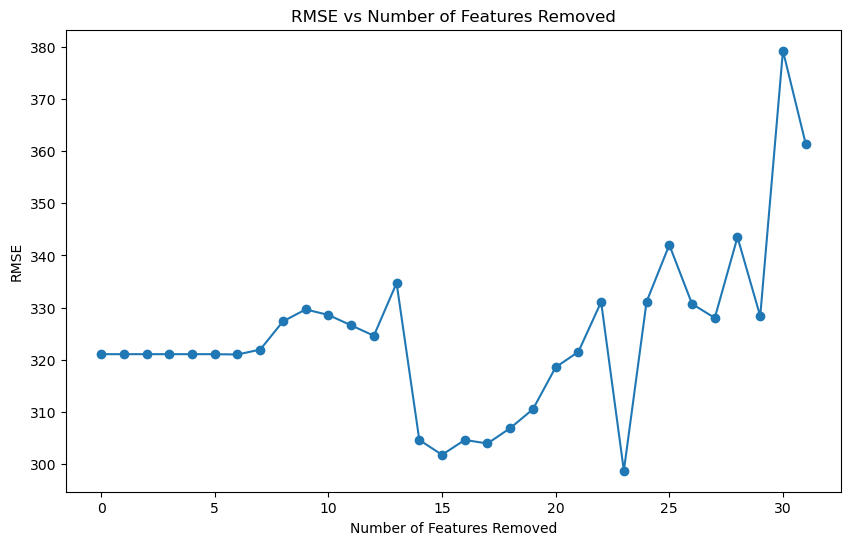

Best Features: ['Turbidez fin cultivo', 'media_PV', 'media_temp_bioreactor', 'Viabilidad final cultivo', 'Volumen de cultivo', 'Centrifugación 2 turbidez', 'Turbidez inicio cultivo_cultivo_final', 'temperature_preinoculo', 'línea 1.2', 'línea 2.1']
Lowest RMSE: 298.7297271559476


In [7]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Initial training
xgbr = XGBRegressor(n_estimators=100, random_state=42)
xgbr.fit(X_train, y_train)

# Get initial feature importances
importances = xgbr.feature_importances_
feature_names = X_train.columns
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Store RMSE values
rmse_values = []
features_list = []

# Iteratively remove the least important feature
while len(feature_importances) > 1:
    # Evaluate the model
    y_pred = xgbr.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmse_values.append(rmse)
    features_list.append(feature_importances['Feature'].tolist())

    # Remove the least important feature
    least_important_feature = feature_importances.iloc[-1, 0]
    X_train = X_train.drop(columns=[least_important_feature])
    X_val = X_val.drop(columns=[least_important_feature])

    # Retrain the model
    xgbr.fit(X_train, y_train)

    # Get new feature importances
    importances = xgbr.feature_importances_
    feature_names = X_train.columns
    feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot RMSE values
plt.figure(figsize=(10, 6))
plt.plot(range(len(rmse_values)), rmse_values, marker='o')
plt.xlabel('Number of Features Removed')
plt.ylabel('RMSE')
plt.title('RMSE vs Number of Features Removed')
plt.show()

# Print the features that resulted in the lowest RMSE
min_rmse_index = np.argmin(rmse_values)
best_features = features_list[min_rmse_index]
print("Best Features:", best_features)
print("Lowest RMSE:", rmse_values[min_rmse_index])